In [ ]:
# here we further implement packman mask

In [ ]:
### calculate radial profile
import  numpy               as     np
from    scripts.tools       import *
from    scripts.packman     import *
from    astropy.table       import Table
from    astropy.io          import fits
from    astropy.cosmology   import Planck18
import  astropy.units       as     u
import  matplotlib.pyplot   as     plt
import  matplotlib.colors   as     colors  
from    matplotlib          import use
from    tqdm.notebook       import tqdm
from    concurrent.futures  import ThreadPoolExecutor, as_completed
import  sys, os
from    IPython.display     import clear_output
from    astropy.wcs         import WCS
from    photutils.aperture  import EllipticalAnnulus, EllipticalAperture, aperture_photometry, CircularAperture, CircularAnnulus
obj_lis = Table.read('obj_lis_selected.fits')

import warnings

def K_lambda(line='Ha'):
    """
    Calculate the dust attenuation value k(lambda) from the Calzetti et al. (2000) attenuation curve
    for either H-alpha (656.3 nm) or H-beta (486.1 nm).
    
    Parameters:
        line (str): 'Ha' for H-alpha (656.3 nm) or 'Hb' for H-beta (486.1 nm).
        
    Returns:
        float: Attenuation value k(λ)
    """
    if line == 'Ha':
        wavelength_um = 0.6563  # Hα (656.3 nm)
    elif line == 'Hb':
        wavelength_um = 0.4861  # Hβ (486.1 nm)
    else:
        raise ValueError("Invalid input! Use 'Ha' for H-alpha or 'Hb' for H-beta.")

    if 0.12 <= wavelength_um <= 0.63:
        # UV to optical range (Calzetti 2000)
        k_lambda = 2.659 * (-2.156 + 1.509 / wavelength_um - 0.198 / (wavelength_um ** 2) + 0.011 / (wavelength_um ** 3)) + 4.05
    elif 0.63 < wavelength_um <= 2.2:
        # Near-Infrared range (Calzetti 2000)
        k_lambda = 2.659 * (-1.857 + 1.040 / wavelength_um) + 4.05
    else:
        raise ValueError("Wavelength out of range (0.12 - 2.2 μm).")

    return k_lambda




In [ ]:

def radial_profile(obj, linemap, weight, seg, pixel_length,ha=False):
    # Here we try to use elliptical annuli to extract the radial profile
    # The semi major axis in arcsec, transformed to pixel:
    # The axis ratio
    axis_ratio = obj['q']
    # The position angle
    pa = obj['pa']
    # The center of the object
    center = (linemap.data.shape[0] / 2, linemap.data.shape[1] / 2)
    # A series of elliptical annuli with the same width
    r = np.linspace(0, linemap.data.shape[0]/2, int(linemap.data.shape[0])+1)
    #if ellipse fits is good:
    if obj['f'] == 0:
        # The elliptical annuli
        center_annuli = [EllipticalAperture(center, r[1], r[1] * axis_ratio, theta=-pa * u.deg.to(u.rad))]
        ellip_annuli = [EllipticalAnnulus(center, a_in=r[i], a_out=r[i+1], b_in=r[i] * axis_ratio, b_out=r[i+1] * axis_ratio, theta=-pa * u.deg.to(u.rad)) for i in range(1, len(r)-1)]
        
        final_aperture = center_annuli + ellip_annuli
    #else wse use circular annuli
    else:
        center_annuli = [CircularAperture(center, r[1])]
        final_aperture = center_annuli + [CircularAnnulus(center, r[i], r[i+1]) for i in range(1, len(r)-1)]
    # Initialize arrays to store the results
    ha_r = np.zeros(len(final_aperture))
    ha_r_err = np.zeros(len(final_aperture))
    mask = np.logical_or(seg != obj['ID'],linemap.data<=0)
    # Mask to select the object
    if ha:
        mask_pack = double_packman(linemap.data.shape[0],90,90)
        mask = np.logical_or(mask,mask_pack)
    else:
        mask_pack = double_packman(linemap.data.shape[0],90,90)
        mask = np.logical_or(mask,mask_pack)      
        mask = mask
    # Calculate the area of each annulus
    surface_area = [aperture.area_overlap(linemap,mask=mask,method='subpixel',subpixels=50) for aperture in final_aperture]

    error_data = np.where(weight.data**0.5 > 0, 1 / weight.data**0.5, np.nan)
    error_data[np.isinf(error_data)] = np.nan

    # Loop over each annulus and calculate the surface brightness
    for i, annulus in enumerate(final_aperture):
        phot_table = aperture_photometry(linemap.data, annulus, error=error_data, mask=mask, method='subpixel', subpixels=50)
        ha_r[i] = phot_table['aperture_sum'][0]/surface_area[i]
        ha_r_err[i] = phot_table['aperture_sum_err'][0]    
    return r*pixel_length, ha_r, ha_r_err


#this function will generate the             print(r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err)
#radial table for a given object
def gen_radial_table_ellip(obj,
                     LINE_HA='LINE_HA',      LINE_HB='LINE_HB_CONV',
                     LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB_CONV'):
    try:
        path = f"data_extracted/{file_name(obj,prefix='extracted')}"
        with fits.open(path,mode='update') as hdu:
            if find_data('SEG_MOD',hdu) != None:
                seg_map = find_data('SEG_MOD',hdu)[1].data
            else:
                seg_map = find_data('SEG',hdu)[1].data

            #extract the radial profile surface brightness
            r, ha_r, ha_r_err = radial_profile(obj,
                                            linemap      = find_data(LINE_HA,hdu)[1],
                                            weight       = find_data(LINEWHT_HA,hdu)[1],
                                            seg          = seg_map,
                                            pixel_length = obj['pixel_length'],
                                            ha           = True)      
            
            r, hb_r, hb_r_err = radial_profile(obj,
                                            linemap      = find_data(LINE_HB,hdu)[1],
                                            weight       = find_data(LINEWHT_HB,hdu)[1],
                                            seg          = seg_map,
                                            pixel_length = obj['pixel_length'])

            r, balmer_r_pix, balmer_r_pix_err = radial_profile(obj,
                                            linemap      = find_data('2D_BALMER',hdu)[1],
                                            weight       = find_data('2D_BALMER_ERR',hdu)[1],
                                            seg          = seg_map,
                                            pixel_length = obj['pixel_length'])

            #calculate the balmer decrement
            balmer_r     = ha_r/hb_r
            balmer_r_err = ((ha_r_err/hb_r)**2 + (hb_r_err**2 * (ha_r/hb_r**2)**2))**0.5
            
            #now calculate the extinction
            #color excess
            E_ba = 2.5*np.log10(balmer_r/2.86)
            #attenutation
            A_ba = E_ba/(K_lambda('Hb')-K_lambda('Ha')) * K_lambda('Ha')


            E_pix = 2.5*np.log10(balmer_r_pix/2.86)
            A_pix = E_pix/(K_lambda('Hb')-K_lambda('Ha')) * K_lambda('Ha')

            #columns for the radial table
            cols = [
                fits.Column(name='DISTANCE [kpc]',                       format='E', array=r),
                fits.Column(name='Ha_SURF_BRIGHT [1e-17 erg/s/cm2]',     format='E', array=ha_r),
                fits.Column(name='Ha_SURF_BRIGHT_err [1e-17 erg/s/cm2]', format='E', array=ha_r_err),
                fits.Column(name='Hb_SURF_BRIGHT [1e-17 erg/s/cm2]',     format='E', array=hb_r),
                fits.Column(name='Hb_SURF_BRIGHT_err [1e-17 erg/s/cm2]', format='E', array=hb_r_err),
                fits.Column(name='BALMER_DECREM',                        format='E', array=balmer_r),
                fits.Column(name='BALMER_DECREM_ERR',                    format='E',array=balmer_r_err),
                fits.Column(name='E_BV',                                  format='E', array=E_ba),
                fits.Column(name='A_Ha',                                  format='E', array=A_ba)
            ]

            cols_pix = [
                fits.Column(name='DISTANCE [kpc]',                       format='E', array=r),
                fits.Column(name='Ha_SURF_BRIGHT [1e-17 erg/s/cm2]',     format='E', array=ha_r),
                fits.Column(name='Ha_SURF_BRIGHT_err [1e-17 erg/s/cm2]', format='E', array=ha_r_err),
                fits.Column(name='Hb_SURF_BRIGHT [1e-17 erg/s/cm2]',     format='E', array=hb_r),
                fits.Column(name='Hb_SURF_BRIGHT_err [1e-17 erg/s/cm2]', format='E', array=hb_r_err),
                fits.Column(name='BALMER_DECREM',                        format='E', array=balmer_r_pix),
                fits.Column(name='BALMER_DECREM_ERR',                    format='E',array=balmer_r_pix_err),
                fits.Column(name='E_BV',                                  format='E', array=E_pix),
                fits.Column(name='A_Ha',                                  format='E', array=A_pix)
            ]
            
            #choose the right name for saving the radial table
            if 'CONV' in LINE_HB:
                name_addon = '_CONV'
            else:
                name_addon = ''
            if 'BG' not in LINE_HA:
                name = f'RAD_PROFILE_ellip_{name_addon}'
                new_table = fits.BinTableHDU.from_columns(cols, name=name+'_PACK')
                new_table_pix = fits.BinTableHDU.from_columns(cols_pix, name=name+'_PACK_PIX')
            else:
                name = f'RAD_PROFILE_ellip{name_addon}_BG'
                new_table = fits.BinTableHDU.from_columns(cols, name=name+'_PACK')
                new_table_pix = fits.BinTableHDU.from_columns(cols_pix, name=name+'PACK_PIX')



            #save or update table
            save_update(new_table,hdu)
            save_update(new_table_pix,hdu)
            hdu.flush()
            return f"{obj['subfield']}-{obj['ID']} processed"
    except Exception as e:
            return f"! {obj['subfield']}-{obj['ID']} failed, error{e}"

def cat_process(obj_lis,
                LINE_HA,   LINE_HB,
                LINEWHT_HA, LINEWHT_HB,
                max_threads=1):
        print(f'start process,{LINE_HA},{LINE_HB}')
        results = []
        if max_threads > 1 :
            with ThreadPoolExecutor(max_threads) as executor:
                futures = {executor.submit(
                    gen_radial_table_ellip,
                    obj,LINE_HA,LINE_HB,LINEWHT_HA,LINEWHT_HB
                                            ): obj for obj in obj_lis}
                for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                    results.append(future.result())
            return results
        else:
            for obj in tqdm(obj_lis):
                results.append(gen_radial_table_ellip(obj,LINE_HA,LINE_HB,LINEWHT_HA,LINEWHT_HB))
            return results


def main():
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    obj_lis = Table.read('obj_lis_selected.fits')
    '''
    results1 = cat_process(obj_lis,
                        LINE_HA='LINE_HA',LINE_HB='LINE_HB',
                        LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB',max_threads=1)
    errorcounting(results1)
    '''
    results3 = cat_process(obj_lis[obj_lis['manual_select']=='keep'],
                        LINE_HA='LINE_HA',LINE_HB='LINE_HB_CONV',
                        LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB_CONV',max_threads=1)
    errorcounting(results3)

'''
    results2 = cat_process(obj_lis,
                        LINE_HA='LINE_HA_BG',LINE_HB='LINE_HB_BG',
                        LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB',max_threads=6)
    errorcounting(results2)
    
    results4 = cat_process(obj_lis,
                        LINE_HA='LINE_HA_BG',LINE_HB='LINE_HB_CONV_BG',
                        LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB_CONV',max_threads=6)
    errorcounting(results4)
'''
if __name__ == '__main__':
    main()



start process,LINE_HA,LINE_HB_CONV


  0%|          | 0/87 [00:00<?, ?it/s]

total number of obj processed: 87
number of failed obj 2


l:\Balmer-Decrement_3DHST\scripts\packman.py:17: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC))


  0%|          | 0/158 [00:00<?, ?it/s]

C:\Users\26715\AppData\Local\Temp\ipykernel_47468\778443336.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma_r')
C:\Users\26715\AppData\Local\Temp\ipykernel_47468\778443336.py:88: RuntimeWarning: invalid value encountered in log10
  fig.suptitle(f"{obj['subfield']}- {obj['ID']}, Mass: {round(np.log10(obj['mass']), 2)}[log$M_\odot$], Redshift: {round(obj['z_MAP'], 2)}, $r_e: {round(r_eff/0.1)} [kpc]$", fontsize=16)


KeyboardInterrupt: 

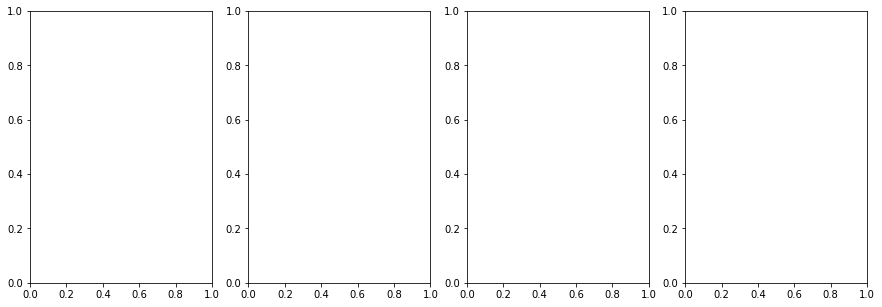

In [26]:
plt.imshow(double_packman(50,45,45),cmap='plasma_r')
from matplotlib.patches import Ellipse
from matplotlib import cm
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv


def plot_balmer_decrem(obj, plot, plot_var, crop_size=50):

        # Construct the path to the FITS file
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"
        
        # Open the FITS file
        with fits.open(path) as hdu:
            # Determine the center of the image
            shape = hdu[3].data.shape[0]
            si = (shape - crop_size) // 2; 
            ei = si + crop_size

            #extract segmentation map
            if find_data('SEG_MOD',hdu) != None:
                seg = find_data('SEG_MOD',hdu)[1].data
            else:
                seg = find_data('SEG',hdu)[1].data

            #effective radius (in arcsec)
            r_eff = obj['re']
             
            # Create a figure with subplots
            fig, axes = plt.subplots(1, 4, figsize=(15, 5))
            axes = axes.flatten()

            # Loop through the specified image names and plot them
            #here i try to add segmentation map effect to the image
            for i, name in enumerate(['DSCI', 'LINE_HA', 'LINE_HB_CONV', '2D_BALMER']):
                image = find_data(name, hdu)[1]
                titles = {
                        "DSCI": find_data('DSCI',hdu)[1].header['EXTTYPE'],
                        "LINE_HA": r"H$\alpha$",
                        "LINE_HB_CONV": r"H$\beta$",
                        "2D_BALMER": r'$H\alpha / H\beta$'
                        }
                data = image.data[si:ei, si:ei]
                # Extract the segmentation map for the same region
                seg_crop = seg[si:ei, si:ei]
                # Create a mask where the segmentation map matches the object ID
                mask = np.logical_and(seg_crop == obj['ID'],np.logical_not(double_packman(crop_size,45,45)))
                
                ax = axes[i]
                ax.tick_params(direction='in', which='both', top=True, right=True, labelsize=14)

                # Plot the original data with plasma_r colormap
                norm = colors.LogNorm()#vmin=np.nanmin(data),vmax = np.nanmax(data))
                norm = colors.Normalize(vmin=0)
                if name == '2D_BALMER':
                    norm = colors.Normalize(vmin=0, vmax=10)
                im = ax.imshow(np.where(mask, data, np.nan), norm=norm, origin='lower', cmap='plasma_r')
                
                # Convert the colormap to grayscale
                cmap = cm.get_cmap('plasma_r')
                cmap_colors = cmap(np.arange(cmap.N))
                hsv_colors = rgb_to_hsv(cmap_colors[:, :3])
                hsv_colors[:, 1] = 0  # Set saturation to 0 to convert to grayscale
                gray_cmap = colors.ListedColormap(hsv_to_rgb(hsv_colors))

                # Overlay the segmentation map with gray colormap and lower transparency
                ax.imshow(np.where(np.logical_not(mask), data, np.nan), norm=norm, origin='lower', cmap=gray_cmap, alpha=0.5)
                
                if obj['f'] == 0:
                # Plot a circle representing the effective radius
                    ellipse = Ellipse((crop_size/2-1, crop_size/2-1), 
                                    width=2*r_eff/0.1,
                                    height=2*obj['q']*r_eff/0.1, angle=-obj['pa'],
                                    color='cyan', fill=False, linestyle='--', label=r'$r_e$', linewidth=2)
                    ax.add_patch(ellipse)
                else:
                    circ = plt.Circle((crop_size/2-1, crop_size/2-1), r_eff/0.1, color='cyan', fill=False, linestyle='--', label=r'$r_e$', linewidth=2)
                    ax.add_patch(circ)

                ax.plot([3, 7], [4, 4])
                ax.text(5, 5, f"{round(obj['pixel_length'] * 4, 2)} kpc", fontsize=17)
                ax.text(0.05, 0.95, f'{titles[name]}', transform=ax.transAxes, fontsize=18, verticalalignment='top')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                if name == 'DSCI':
                    ax.legend(fontsize=19,loc= 'upper right')

        # Add a big title for the entire figure
        fig.suptitle(f"{obj['subfield']}- {obj['ID']}, Mass: {round(np.log10(obj['mass']), 2)}[log$M_\odot$], Redshift: {round(obj['z_MAP'], 2)}, $r_e: {round(r_eff/0.1)} [kpc]$", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the big title
        plt.savefig('mask/'+f"{obj['subfield']}-{obj['ID']}_mask.png",dpi=300)
        plt.close('all')

for obj in tqdm(obj_lis):
    plot='RAD_PROFILE_CONV'
    plot_var='RAD_PROFILE_ELLIP__CONV_PACK'
    plot_balmer_decrem(obj, plot, plot_var, crop_size=50)